In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import os, sys
import math
import pickle
import model_utils as modutil
import data_utils as datutil
import hmc
import umap
from matplotlib.patches import Circle

/home/rahul/anaconda3/envs/python3-pytorch1/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
# Data loader initialization
trainloader1 = datutil.generate_dataloaders('CIFAR10_TRAIN', batch_size=50, shuffle=False, num_workers=2)
testloader1 = datutil.generate_dataloaders('CIFAR10_TEST', batch_size=10, shuffle=False, num_workers=2)
validloader1 = datutil.generate_dataloaders('CIFAR10_TEST', batch_size=1000, shuffle=False, num_workers=2)

trainloader2 = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TRAIN', batch_size=50000, shuffle=True, num_workers=2)
testloader2 = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TEST', batch_size=10000, shuffle=False, num_workers=2)
validloader2 = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TEST', batch_size=10000, shuffle=False, num_workers=2)

trainloader3 = datutil.generate_dataloaders('GP+ENCODED256_D164_CIFAR10_TRAIN', batch_size=50000, shuffle=True, num_workers=2)
testloader3 = datutil.generate_dataloaders('GP+ENCODED256_D164_CIFAR10_TEST', batch_size=10000, shuffle=False, num_workers=2)
validloader3 = datutil.generate_dataloaders('GP+ENCODED256_D164_CIFAR10_TEST', batch_size=10000, shuffle=False, num_workers=2)

# Cifar-100 interesting classes (used during out-of-class entropy calculation)
interesting_labels = [0, 1, 16, 17, 20, 21, 29, 39, 40, 49, 57, 71, 72, 73, 76]

In [ ]:
# model to train/load/analyse
# user defined params
models = [{'model_type' : "encoded",     # <Kernel_name> + <GP>
    'saved_checkpoint_name' : "",
    'fc_setup' : [150,100],
    'load_model' : False,
    'partial_load' : False,
    'component_pretrained_mods' : ['encoded_depth-164_lr-0.3_mom-0.9_wd-0.0001_gpwd-0.0001_FC-150-100_acc-38.45-2019-09-19-00.57'],
    'train_model' : False,
    'train_epoch' : 5,
    'num_classes' : 100,
    'weight_decay' : 1e-4,
    'predef_test_acc' : 92,
    'depth' : 164,
    'grid_size' : 64,
    'optim_SGD' : True,
    'device' : torch.device('cuda:2'),
    'lr_init' : 0.001,
    'lr_final' : 0.0005,
    'gp_kernel_feature' : 256, # 256, 640
    'print_init_model_state' : False},]

In [ ]:
for model in models:
    
    if 'encoded' not in model['model_type']:
        trainloader = trainloader1
        testloader = testloader1
        validloader = validloader1
    else:
        trainloader = trainloader2
        testloader = testloader2
        validloader = validloader2
        
    print('='*20, "Loading Model", '='*20)
    modutil.refresh_params()
    for propt in model:
        if propt in modutil.__dict__:
            modutil.__dict__[propt] = model[propt]
        else:
            print("Model property '%s' not found!"%(propt))
    
    #load / train the model
    modutil.load_train(trainloader, testloader)
    if model['train_model']:
        print("Saving model!")
        modutil.save_model()

    # param_list = param_chain if 'mcmc' in model['model_type'] else []
    # Perform evaluation on model
    # modutil.validate("out-of-class", validloader, interesting_labels=interesting_labels)
    print("Validation (out of class) data analysis performed")

    modutil.validate("test", testloader, accuracy_only=False)
    print("Test data analysis performed")


In [ ]:
# directory = '/home/rahul/work/NN_with_prior_weights/swa-paper_experiments/saved_predictions/untitled/'
directory = 'saved_predictions/'
test_file = directory + models[0]['saved_checkpoint_name'] + '.testpred'
prob_cutoffs = [(i+1)/30.0 for i in range(30)]

with open(test_file, 'rb') as test_file:
    stats = pickle.load(test_file)
    targets = stats['targets']
    preds = stats['predictions']
    probs = stats['probs']
    ece, ece_avg = modutil.calculate_ECE(probs, preds, targets, ECE_bin=prob_cutoffs)

print(sum([target==pred for target, pred in zip(targets, preds)]))
print(ece, ece_avg)

In [9]:
trainloader2 = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TRAIN', batch_size=50000, shuffle=False, num_workers=2)
testloader2 = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TEST', batch_size=200, shuffle=False, num_workers=2)
trainloader3 = datutil.generate_dataloaders('Fast_resnet30000MixupCutout_train', batch_size=50000, 
                                            shuffle=False, num_workers=2)
testloader3 = datutil.generate_dataloaders('Fast_resnet30000MixupCutout_test', batch_size=200, 
                                           shuffle=False, num_workers=2)


reducer1 = umap.UMAP(spread=20)
for data in trainloader2:
    image, label = data
    image = image.cpu().numpy()
    label = label.cpu().numpy()

all_images = image
all_labels = label

for data in testloader2:
    image, label = data
    image = image.cpu().numpy()
    label = label.cpu().numpy()
    
all_images = np.concatenate((all_images, image), axis=0)
all_labels = np.concatenate((all_labels, label), axis=0)

embedding1 = reducer1.fit_transform(all_images)
train_images1 = embedding1[:50000]
train_labels1 = all_labels[:50000]
test_images1 = embedding1[50000:]
test_labels1 = all_labels[50000:]

reducer2 = umap.UMAP(spread=20)
for data in trainloader3:
    image, label = data
    image = image.cpu().numpy()
    label = label.cpu().numpy()

all_images = image
all_labels = label

for data in trainloader3:
    image, label = data
    image = image.cpu().numpy()
    label = label.cpu().numpy()
    
all_images = np.concatenate((all_images, image), axis=0)
all_labels = np.concatenate((all_labels, label), axis=0)

embedding2 = reducer2.fit_transform(all_images)
train_images2 = embedding2[:50000]
train_labels2 = all_labels[:50000]
test_images2 = embedding2[50000:]
test_labels2 = all_labels[50000:]

/home/rahul/anaconda3/envs/python3-pytorch1/lib/python3.7/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/rahul/anaconda3/envs/python3-pytorch1/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/python3-pytorch1/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/rahul/anaconda3/envs/python3-pytorch1/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for par

In [7]:
len(all_images)

400

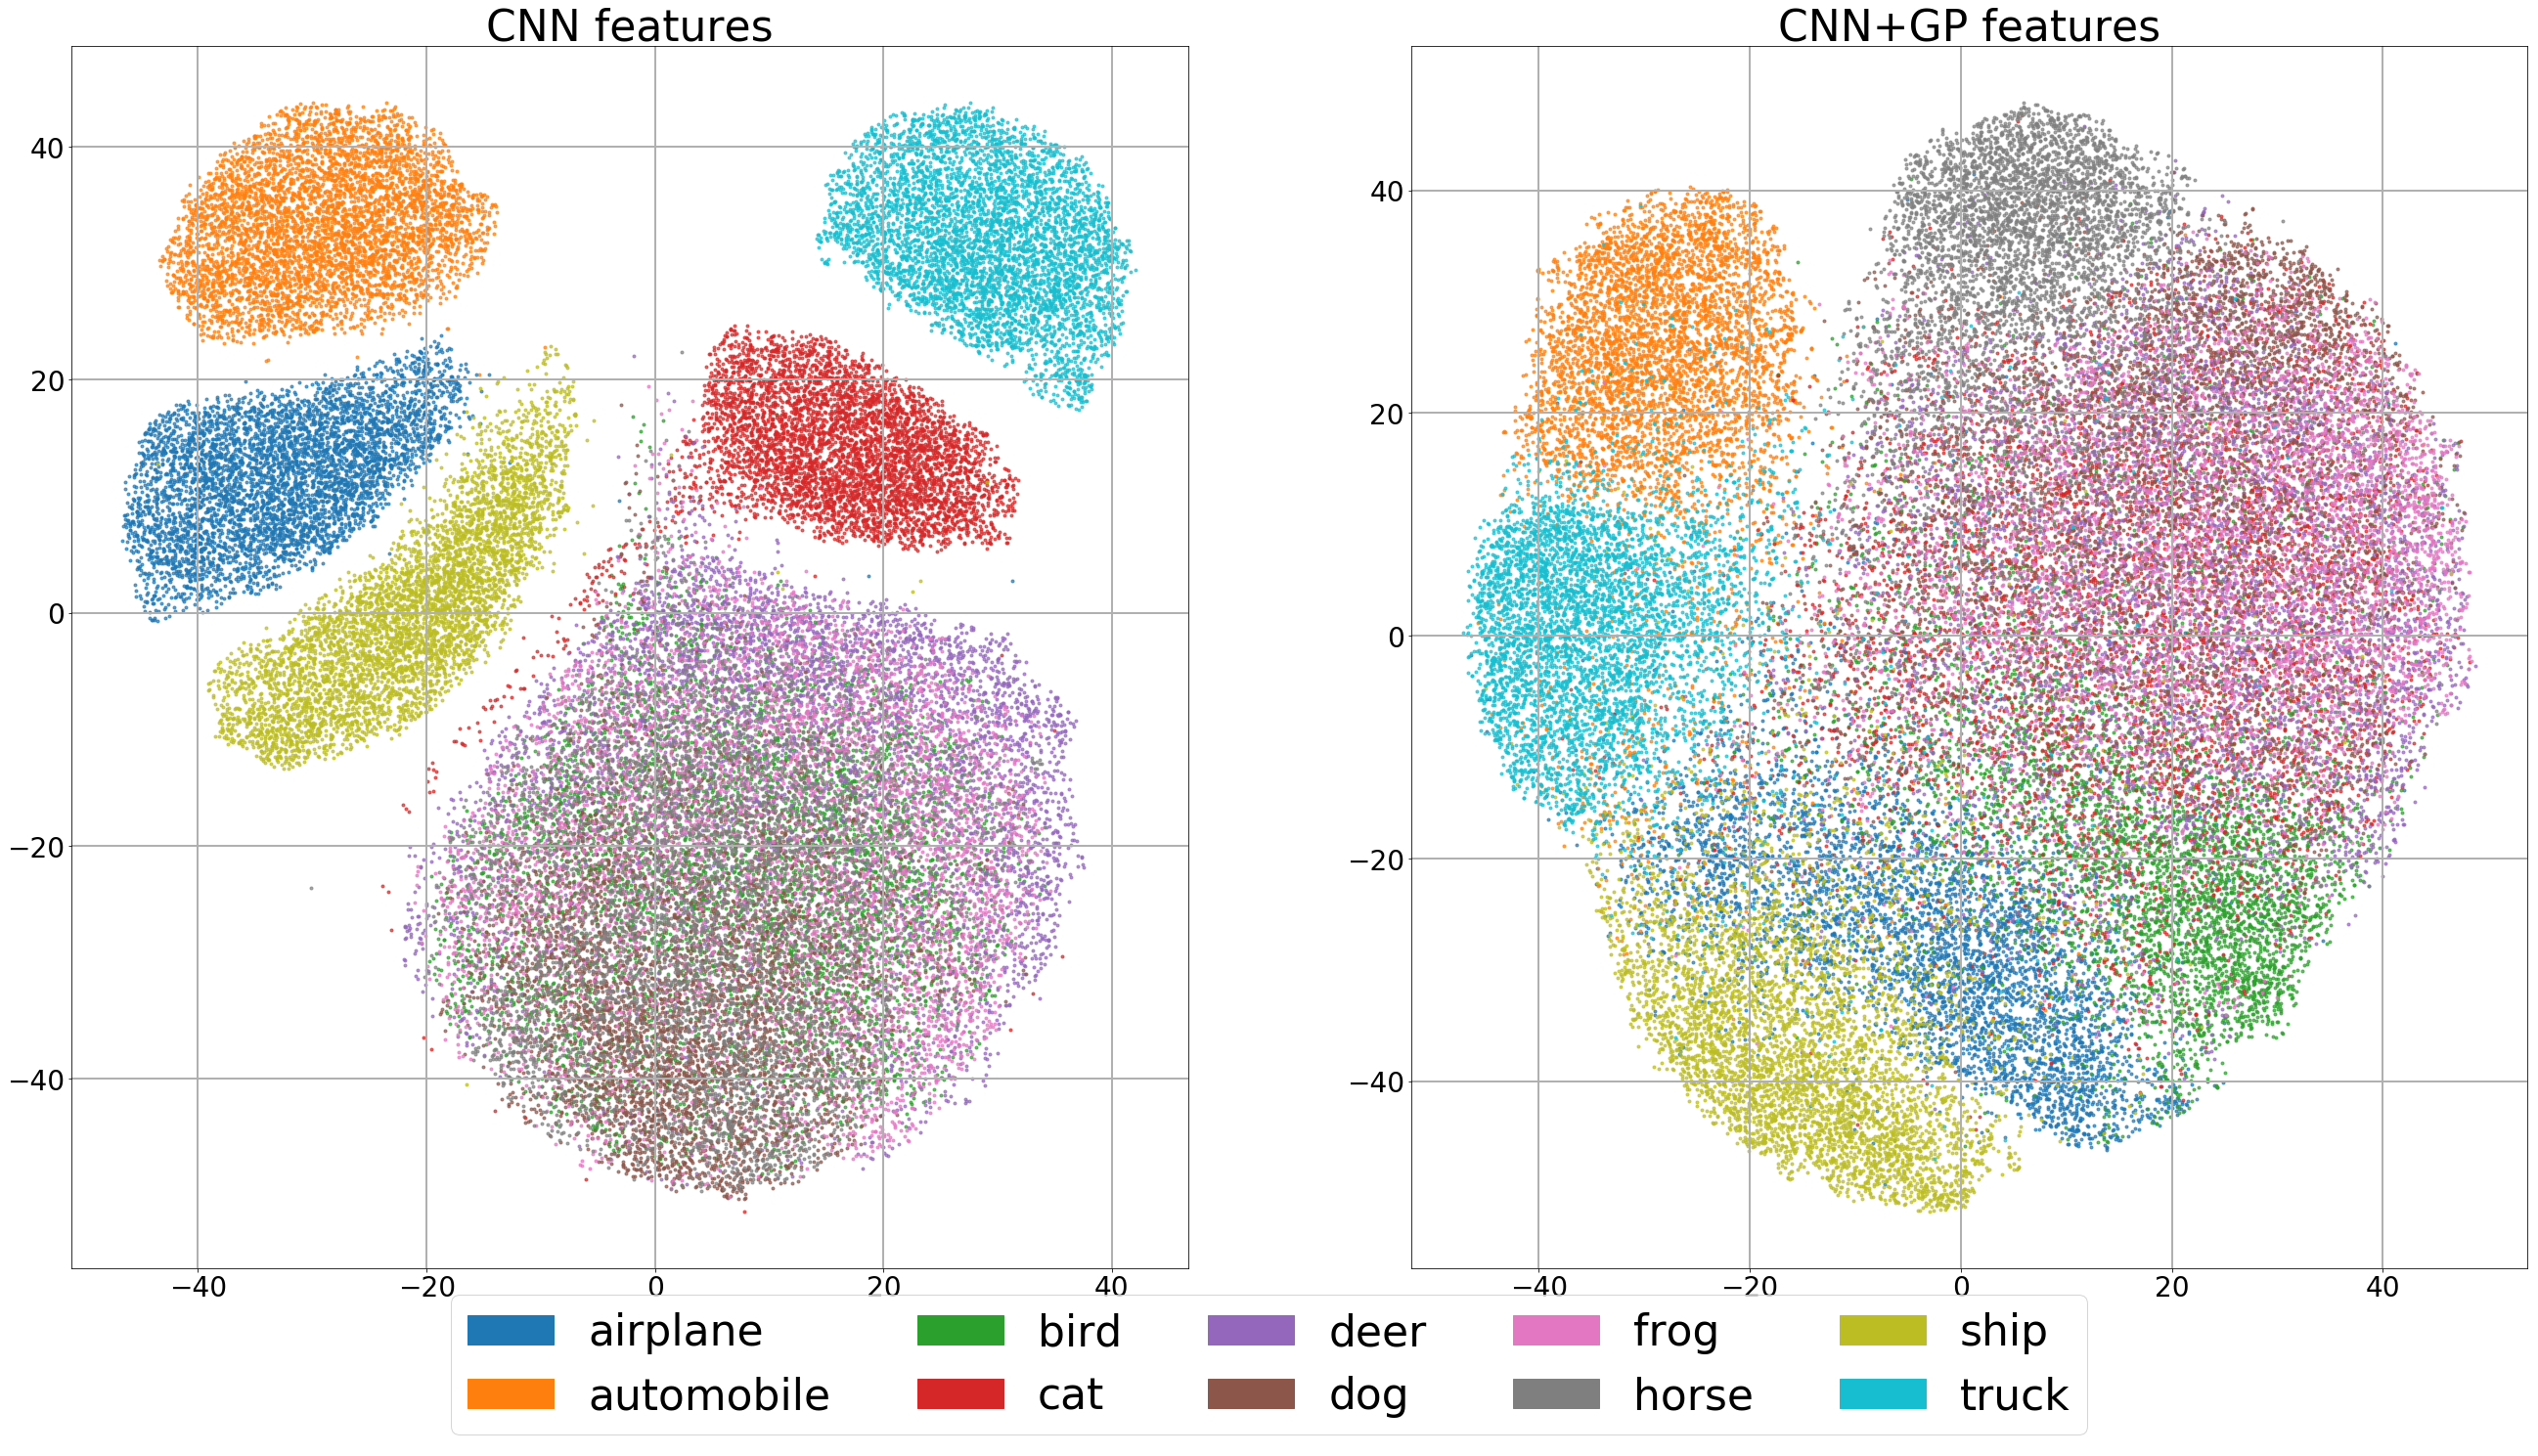

In [10]:
from matplotlib.patches import Circle
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,23))
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

ax = plt.subplot(1,2,1)
for lab in range(10):
    plt.scatter(train_images1[train_labels1==lab,0], train_images1[train_labels1==lab,1], 
                c='C'+str(lab), marker='.', alpha=0.7)
plt.title('CNN features', fontsize=44)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)
ax.xaxis.grid(linewidth=2, alpha=1, zorder=1)
ax.yaxis.grid(linewidth=2, alpha=1, zorder=1)

ax = plt.subplot(1,2,2)
for lab in range(10):
    plt.scatter(train_images2[train_labels2==lab,0], train_images2[train_labels2==lab,1], 
                c='C'+str(lab), marker='.', alpha=0.7)
plt.title('CNN+GP features', fontsize=44)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)
ax.xaxis.grid(linewidth=2, alpha=1, zorder=1)
ax.yaxis.grid(linewidth=2, alpha=1, zorder=1)

custom_lines = [Circle(xy=(0, 0), radius=2, color='C'+str(lab)) for lab in range(10)]
fig.legend(custom_lines, cifar10_labels, loc = 'lower center', prop={'size': 44}, ncol=5)
plt.savefig('plots/UMAP_Missclassifications.png')

In [ ]:
def get_standard_dset(label_dict, standardize=True):
    
    keys = list(label_dict.keys())
    labels = [label_dict[key] for key in keys]
    
    for data in trainloader2:
        image, label = data
        image = image.cpu().numpy()
        label = label.cpu().numpy()
        image1_l1 = image[label==labels[0]]
        image1_l2 = image[label==labels[1]]

    all_mean = np.mean(image, axis=0)
    all_std = np.std(image, axis=0)

    if standardize:
        image1_l1 = (image1_l1 - all_mean) / all_std
        image1_l2 = (image1_l2 - all_mean) / all_std

    for data in trainloader3:
        image, label = data
        image = image.cpu().numpy()
        label = label.cpu().numpy()
        image2_l1 = image[label==label[0]]
        image2_l2 = image[label==label[1]]

    all_mean = np.mean(image, axis=0)
    all_std = np.std(image, axis=0)

    if standardize:
        image2_l1 = (image2_l1 - all_mean) / all_std
        image2_l2 = (image2_l2 - all_mean) / all_std

    return image1_l1, image1_l2, image2_l1, image2_l2

In [ ]:
def get_KNN_dists(label_dict, standardize=True):

    keys = list(label_dict.keys())
    labels = [label_dict[key] for key in keys]

    image1_l1, image1_l2, image2_l1, image2_l2 = get_standard_dset(label_dict, standardize)
    
    from sklearn.neighbors import NearestNeighbors
    nbrs1_l1 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(image1_l1)
    nbrs1_l2 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(image1_l2)
    nbrs2_l1 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(image2_l1)
    nbrs2_l2 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(image2_l2)

    l1KNN1, _ = nbrs1_l1.kneighbors(image1_l1)
    l2KNN1, _ = nbrs1_l2.kneighbors(image1_l2)
    l1KNN2, _ = nbrs2_l1.kneighbors(image2_l1)
    l2KNN2, _ = nbrs2_l2.kneighbors(image2_l2)

    from scipy.spatial.distance import cdist

    l11_l21 = cdist(image1_l1, image1_l2)
    l12_l22 = cdist(image2_l1, image2_l2)

    dists1_l1_KNN10 = []
    for i in range(len(image1_l1)):
        row = l11_l21[i,:]
        row.sort()
        dists1_l1_KNN10.append( (np.average(l1KNN1[i]), np.average(row[:10])) )
    print("%s 1 done!"%keys[0])

    dists1_l2_KNN10 = []
    for i in range(len(image1_l2)):
        row = l11_l21[:,i]
        row.sort()
        dists1_l2_KNN10.append( (np.average(l2KNN1[i]), np.average(row[:10])) )
    print("%s 1 done!"%keys[1])

    dists2_l1_KNN10 = []
    for i in range(len(image2_l1)):
        row = l12_l22[i,:]
        row.sort()
        dists2_l1_KNN10.append( (np.average(l1KNN2[i]), np.average(row[:10])) )
    print("%s 2 done!"%keys[0])

    dists2_l2_KNN10 = []
    for i in range(len(image2_l2)):
        row = l12_l22[:,i]
        row.sort()
        dists2_l2_KNN10.append( (np.average(l2KNN2[i]), np.average(row[:10])) )
    print("%s 2 done!"%keys[1])
    
    return np.array(dists1_l1_KNN10), np.array(dists1_l2_KNN10), np.array(dists2_l1_KNN10), np.array(dists2_l2_KNN10)


In [ ]:
def plot_KNN_dists(label_dict, standardize=True):

    keys = list(label_dict.keys())
    labels = [label_dict[key] for key in keys]
    
    dists1_l1_KNN10, dists1_l2_KNN10, dists2_l1_KNN10, dists2_l2_KNN10 = get_KNN_dists(label_dict, standardize)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

    lines = [i for i in range(4)]

    ax = plt.subplot(1,2,1)
    lines[0] = plt.scatter(dists1_l1_KNN10[:,0], dists1_l1_KNN10[:,1], c='C'+str(labels[0]), marker='.', alpha=0.4)
    lines[1] = plt.scatter(dists1_l2_KNN10[:,1], dists1_l2_KNN10[:,0], c='C'+str(labels[1]), marker='.', alpha=0.4)
    plt.plot((7,28), (7,28), 'r--', linewidth=4, alpha = 0.4)

    plt.xlim((7,25))
    plt.ylim((7,25))
    plt.xlabel('Distance to %s cluster mean'%keys[1], fontdict={'size':16})
    plt.ylabel('Distance to %s cluster mean'%keys[0], fontdict={'size':16})
    plt.title('CNN features', fontsize=16)

    ax = plt.subplot(1,2,2)
    plt.scatter(dists2_l1_KNN10[:,0], dists2_l1_KNN10[:,1], c='C'+str(labels[0]), marker='.', alpha=0.4)
    plt.scatter(dists2_l2_KNN10[:,1], dists2_l2_KNN10[:,0], c='C'+str(labels[1]), marker='.', alpha=0.4)
    plt.plot((7,28), (7,28), 'r--', linewidth=4, alpha = 0.4)

    plt.xlim((7,25))
    plt.ylim((7,25))
    plt.xlabel('Distance to %s cluster mean'%keys[1], fontdict={'size':16})
    plt.ylabel('Distance to %s cluster mean'%keys[0], fontdict={'size':16})
    plt.title('CNN+GP features', fontsize=16)

    custom_lines = [Circle(xy=(0, 0), radius=2, color='C'+str(lab)) for lab in labels]
    fig.legend(custom_lines, keys, loc = 'upper center', prop={'size': 18}, ncol=5)
    plt.savefig('plots/%s_vs_%s_KNN10.png'%(keys[1], keys[0]))

In [ ]:
def plot_cluster_dists(label_dict, standardize=True):
    
    from matplotlib.patches import Circle
    
    keys = list(label_dict.keys())
    labels = [label_dict[key] for key in keys]
    
    image1_l1, image1_l2, image2_l1, image2_l2 = get_standard_dset(label_dict, standardize)
    
    dist = lambda x, y : np.sqrt(sum((x-y)**2))

    mean1_l1 = np.mean(image1_l1, axis=0)
    mean1_l2 = np.mean(image1_l2, axis=0)

    mean2_l1 = np.mean(image2_l1, axis=0)
    mean2_l2 = np.mean(image2_l2, axis=0)

    dists1_l1 = np.array([(dist(image, mean1_l2), dist(image, mean1_l1)) for image in image1_l1])
    dists1_l2 = np.array([(dist(image, mean1_l2), dist(image, mean1_l1)) for image in image1_l2])

    dists2_l1 = np.array([(dist(image, mean2_l2), dist(image, mean2_l1)) for image in image2_l1])
    dists2_l2 = np.array([(dist(image, mean2_l2), dist(image, mean2_l1)) for image in image2_l2])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(33,16))

    lines = [i for i in range(4)]
    
    ax = plt.subplot(1,2,1)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    lines[0] = plt.scatter(dists1_l1[:,0], dists1_l1[:,1], c='C'+str(labels[0]), marker='.', alpha=0.5)
    lines[1] = plt.scatter(dists1_l2[:,0], dists1_l2[:,1], c='C'+str(labels[1]), marker='.', alpha=0.5)
    plt.xlim((7,30))
    plt.ylim((7,30))
    plt.plot([7,30], [7,30], 'k--', linewidth=4, alpha=0.4)
    plt.xlabel("Distance to '%s' cluster mean"%keys[1], fontdict={'size':31})
    plt.ylabel("Distance to '%s' cluster mean"%keys[0], fontdict={'size':31})
    plt.title('CNN features', fontsize=32)
    ax.xaxis.grid(linewidth=2, alpha=0.4, zorder=1)
    ax.yaxis.grid(linewidth=2, alpha=0.4, zorder=1)
    
    ax = plt.subplot(1,2,2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.scatter(dists2_l1[:,0], dists2_l1[:,1], c='C'+str(labels[0]), marker='.', alpha=0.5)
    plt.scatter(dists2_l2[:,0], dists2_l2[:,1], c='C'+str(labels[1]), marker='.', alpha=0.5)
    plt.xlim((7,30))
    plt.ylim((7,30))
    plt.plot([7,30], [7,30], 'k--', linewidth=4, alpha=0.4)
    plt.xlabel("Distance to '%s' cluster mean"%keys[1], fontdict={'size':31})
    plt.ylabel("Distance to '%s' cluster mean"%keys[0], fontdict={'size':31})
    plt.title('CNN+GP features', fontsize=32)
    ax.xaxis.grid(linewidth=2, alpha=0.4, zorder=1)
    ax.yaxis.grid(linewidth=2, alpha=0.4, zorder=1)

    custom_lines = [Circle(xy=(0, 0), radius=2, color='C'+str(lab)) for lab in labels]
    fig.legend(custom_lines, keys, loc = 'lower center', prop={'size': 34}, ncol=5)
    plt.savefig('plots/%s_vs_%s.png'%(keys[0], keys[1]))

In [ ]:
plot_cluster_dists({'Automobile' : 1, 'Truck' : 9}, True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
line = [0, 0]

plt.subplot(1,2,1)
line[0] = plt.hist(np.log(dists1_deer_KNN10[:,0]) - np.log(dists1_deer_KNN10[:,1]), 
                   bins=100, density=True, alpha = 0.7, label='CNN', color='C0')
line[1] = plt.hist(np.log(dists2_deer_KNN10[:,0]) - np.log(dists2_deer_KNN10[:,1]),
                   bins=100, density=True, alpha = 0.7, label='CNN+GP', color='C1')

from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color='C0', lw=8),
                Line2D([0], [0], color='C1', lw=8)]
plt.title('Deer log(deer dist / horse dist)')

plt.subplot(1,2,2)
line[0] = plt.hist(np.log(dists1_horse_KNN10[:,0]) - np.log(dists1_horse_KNN10[:,1]), 
                   bins=100, density=True, alpha = 0.7, label='CNN', color='C0')
line[1] = plt.hist(np.log(dists2_horse_KNN10[:,0]) - np.log(dists2_horse_KNN10[:,1]),
                   bins=100, density=True, alpha = 0.7, label='CNN+GP', color='C1')
plt.title('Horse log(horse dist / deer dist)')

from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color='C0', lw=8),
                Line2D([0], [0], color='C1', lw=8)]
fig.legend(custom_lines, ['CNN', 'CNN+GP'], ncol=2, loc='upper center')
plt.savefig('plots/DeerDist_HorseDist.pdf')

In [ ]:
modutil.encode_dump('CIFAR10GPModelEncoded164ResNet_CIFAR100_256.pt', trainloader)
modutil.encode_dump('CIFAR10GPModelEncoded164ResNet_CIFAR100_256_test', testloader, evalmode=True)
modutil.encode_dump('CIFAR10GPModelEncoded164ResNet_CIFAR100_256_valid', validloader1, evalmode=True)